# Visual Question Answering in MXNET Gluon

#### 참고
 * http://gluon.mxnet.io/chapter08_computer-vision/visual-question-answer.html

#### 관련 논문
 * https://arxiv.org/pdf/1505.00468v6.pdf
 * https://arxiv.org/pdf/1606.01847.pdf

#### Demo for Visual Question Answering
 * http://visualqa.csail.mit.edu/

* predict the **answer** of a given **question** related to an **image**
* Visual question answering(VQA) is a task focusing on providing a **natural language answer given any image and any open-ended question.** This task requires a deep understanding and reasoning of the image combined with the question: a joint representation of both **visual and textual input.**

## VQA Dataset

* In the VQA dataset, for each sample, there is **one image and one question. **
* The label is the answer for the question regarding the image. 
* You can download the VQA1.0 dataset from VQA website.

* Examples of free-form, open-ended questions collected for images

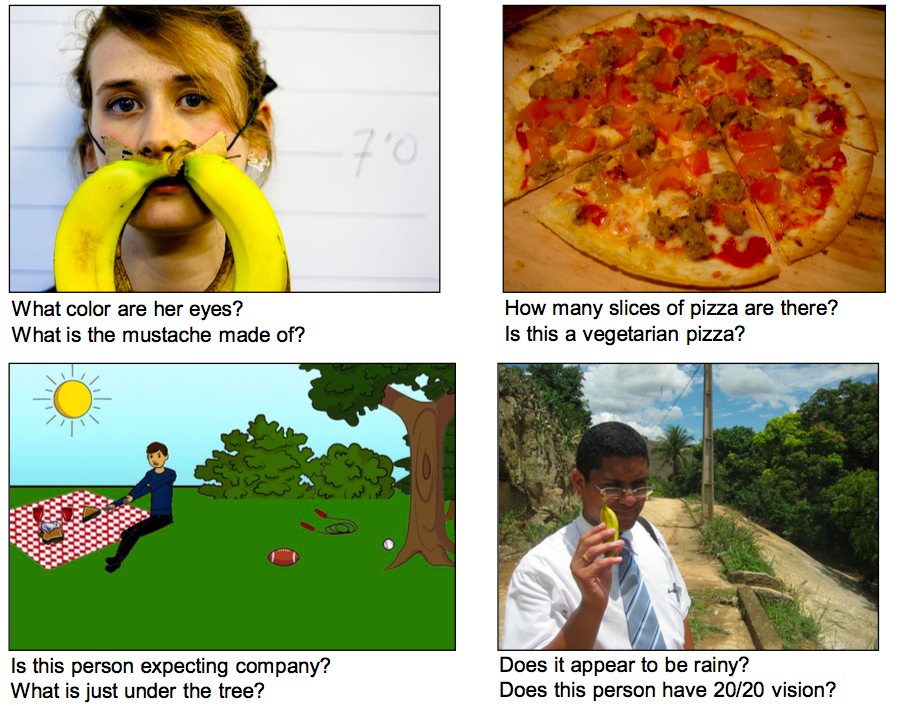

In [3]:
from IPython.display import Image
Image("/Users/hyemin/Documents/Study/Gluon_study/VQA/example1.png")

##  Feature Extraction : Pretrained Models
* Usually people use pretrained models to extract features from the image and question.

#### Image pretrained model:

* VGG: A key aspect of VGG was to use many convolutional blocks with relatively narrow kernels, followed by a max-pooling step and to repeat this block multiple times.

* Resnet: It is a residual learning framework to ease the training of networks that are substantially deep. It reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions.

#### Question pretrained model:

* Word2Vec: The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The model contains 300-dimensional vectors for 3 million words and phrases.

* Glove: Similar to Word2Vec, it is a word embedding dataset. It contains 100/200/300-dimensional vectors for 2 million words.

* skipthought: This is an encoder-decoder model that tries to reconstruct the surrounding sentences of an encoded passage. Sentences that share semantic and syntactic properties are thus mapped to similar vector representations. Different from the previous two model, this is a sentence based model.

* GNMT encoder: We propose using the encoder of google neural machine translation system to extract the question features.

# Gluon code

In [2]:
from __future__ import print_function
import numpy as np
import mxnet as mx
import mxnet.ndarray as F
import mxnet.contrib.ndarray as C
import mxnet.gluon as gluon
from mxnet.gluon import nn
from mxnet import autograd
import bisect
from IPython.core.display import display, HTML
import logging
logging.basicConfig(level=logging.INFO)
import os
from mxnet.test_utils import download
import json
from IPython.display import HTML, display

## 1.  Define the model

* Parameters

In [4]:
# Some parameters we are going to use
batch_size = 64
ctx = mx.cpu()
compute_size  = batch_size
out_dim = 10000
gpus = 1

### (1) 방법1 : Concatenation 

* Image가 요약된 CNN 정보와 Text가 요약된 RNN 정보를 concatenation으로 합하는 모형
* Text 정보와 Image 정보의 원소별 **상호작용이 전혀 고려되지 않은 모형임**

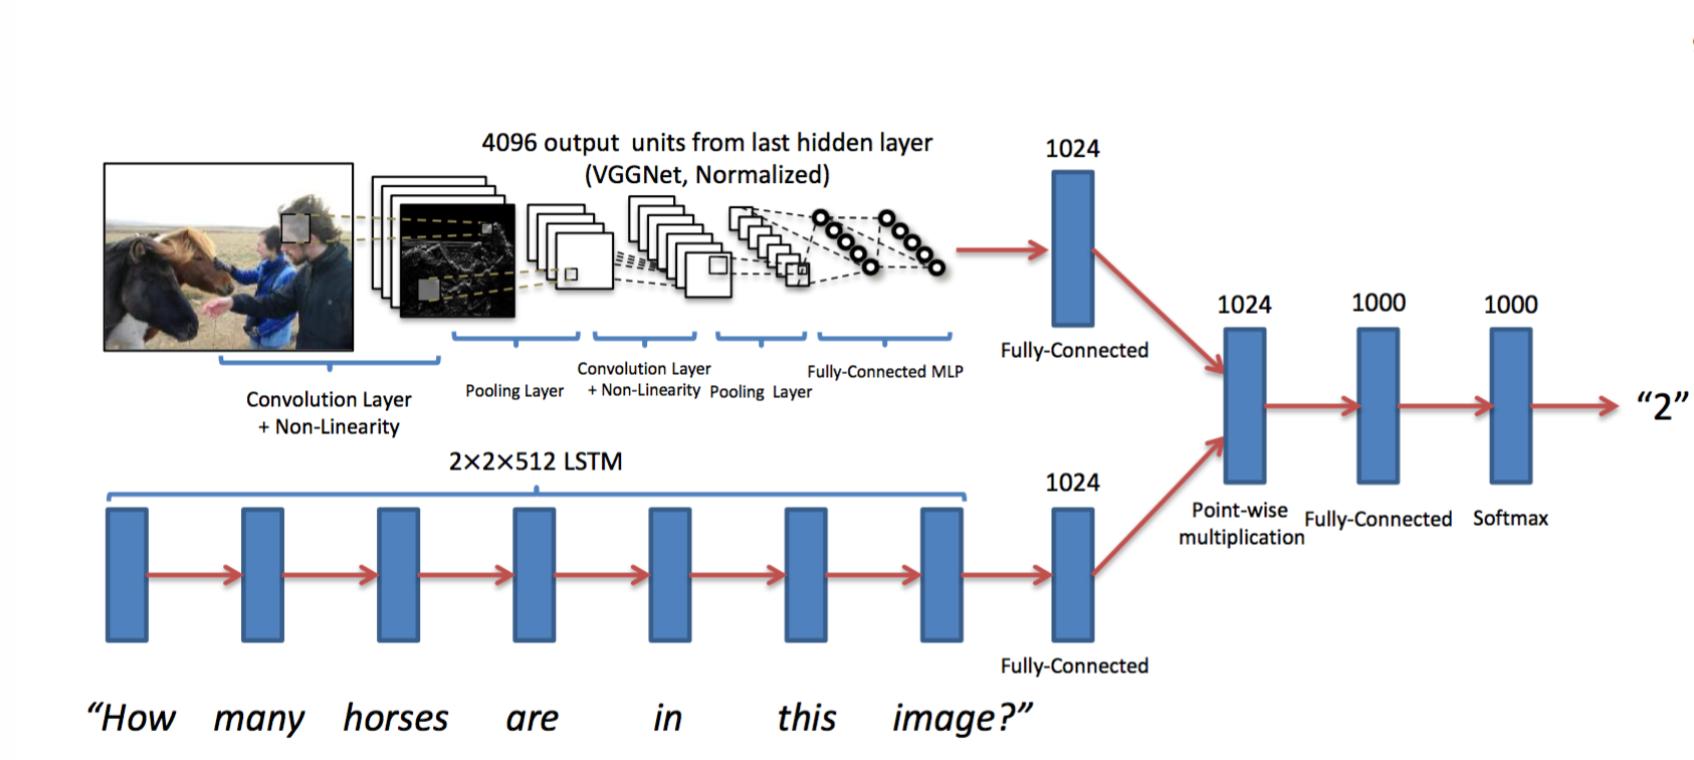

In [5]:
Image("/Users/hyemin/Documents/Study/Gluon_study/VQA/skitch.png")

In [ ]:
* 위 그림에서 숫자만 
(2048)
       -> (3072) -> (8192) -> (1000)
(1024)

In [6]:
class Net1(gluon.Block):
    def __init__(self, **kwargs):
        super(Net1, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm() #Batch normalization
            self.dropout = nn.Dropout(0.3) #Dropout
            self.fc1 = nn.Dense(8192,activation="relu") #Image로부터 나온 Output node 갯수 + 질문의 node 갯수
            self.fc2 = nn.Dense(1000) # 최종 1000개로 요약
            

    def forward(self, x):
        # x[0]: image
        # x[1]: question
        x1 = F.L2Normalization(x[0]) # Feature map의 normalization
        x2 = F.L2Normalization(x[1]) # 질문의 Hidden State값의 normalization
        z = F.concat(x1,x2,dim=1) #하나의 vector로 concat
        z = self.fc1(z)
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [7]:
net1 = Net1()
net1

Net1(
  (bn): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=None)
  (dropout): Dropout(p = 0.3)
  (fc1): Dense(None -> 8192, Activation(relu))
  (fc2): Dense(None -> 1000, linear)
)

### (2) 방법2 : multimodel compact bilinear pooling(MCB)을 통한 정보 blending

* 두개의 multi-modality data로부터 얻은 정보의 원소간 **interaction을 고려**
* Parameter의 갯수가 폭발적으로 증가하나, sketch count라는 기법으로 hash하여 극복
---

* (1) 두 vector를 외적한 후 count sketch 변환을 거치는 것과 (2) sketch count를 적용한 후 convolution하는 것이 동일하다는 것을 보임 (Pham & Pagh, 2013)
 - $\Rightarrow$ Sketch count의 outer product를 구하는 것보다, 각 sketch count의 FFT 변환의 element-wise 곱의 IFFT를 구하면 됨

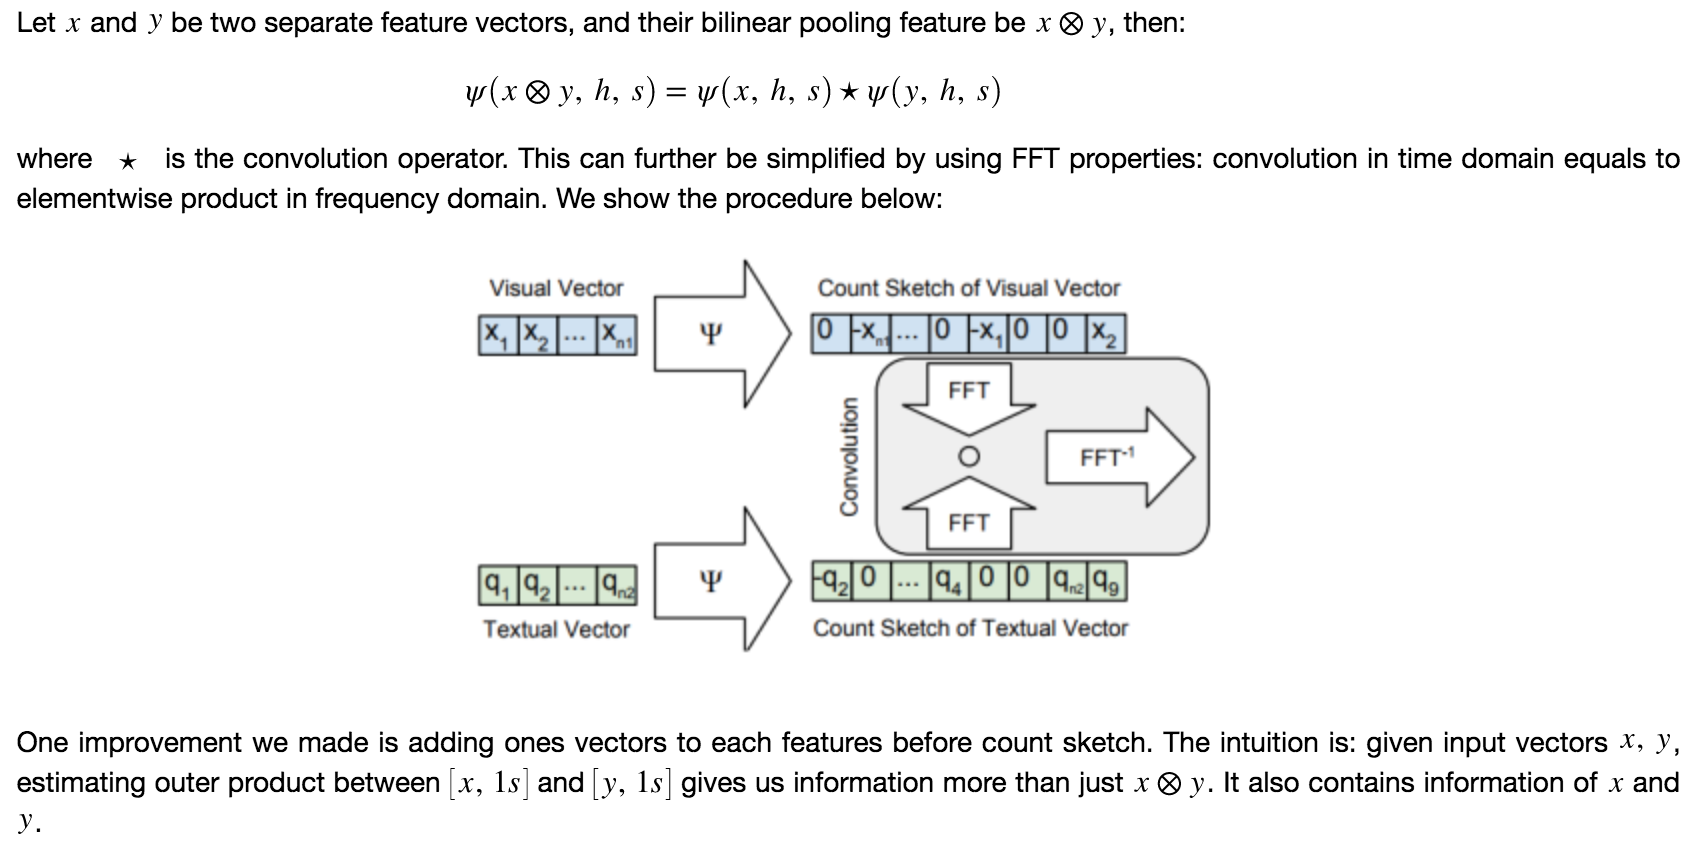

In [8]:
Image("/Users/hyemin/Documents/Study/Gluon_study/VQA/MCB.png")

In [9]:
class Net2(gluon.Block):
    def __init__(self, **kwargs):
        super(Net2, self).__init__(**kwargs)
        with self.name_scope(): #model1과 동일
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm()
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Dense(8192,activation="relu")
            self.fc2 = nn.Dense(1000)
            

    def forward(self, x):
        x1 = F.L2Normalization(x[0]) # Feature map의 normalization
        x2 = F.L2Normalization(x[1]) # 질문의 Hidden State값의 normalization
        
        # One improvement we made is adding ones vectors to each features before count sketch.
        # 1 vector를 덧붙여줌으로써, interaction 뿐만 아니라, image와 text만의 정보도 포함
        # 이유) 단순히 x*y 한 것보다 [x, 1's]*[y, 1's] 한 것이 더 많은 정보 반영(xy, x, y)
        text_ones = F.ones((batch_size/gpus, 2048),ctx = ctx)# make 1's array : batch_size*2048
        img_ones = F.ones((batch_size/gpus, 1024),ctx = ctx) # make 1's array : batch_size*1024
        text_data = F.Concat(x1, text_ones,dim = 1)
        image_data = F.Concat(x2,img_ones,dim = 1)
        
        # Initialize hash tables
        # Random seed to ensure we have same hash function for all samples
        # count sketch 연산
        # S: 해당 위치의 원소의 부호를 바꾸는 역할
        # H: 원소의 순서를 정하는 역할
        ##(1) image
        np.random.seed(0)
        S1 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx) # 3072 차원의 [-1, 1]값이 들어 있는 S vector
        np.random.seed(0)
        H1 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx) # 3072차원을 10000차원으로 줄이기 위한 H vector
        ##(2) text
        np.random.seed(1)
        S2 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx) # 3072 차원의 [-1, 1]값이 들어 있는 S vector
        np.random.seed(1)
        H2 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx) # 3072차원을 10000차원으로 줄이기 위한 H vector
        ## 왜 3072차원을 10000차원으로? outer product는 총 944만개 정도의 parameter가 있는데 이를 10000개로 줄이고자 함
        
        # Count sketch(각각 count sketch 연산을 수행)
        cs1 = C.count_sketch( data = image_data, s=S1, h = H1 ,name='cs1',out_dim = out_dim)
        cs2 = C.count_sketch( data = text_data, s=S2, h = H2 ,name='cs2',out_dim = out_dim) 
        
        # FFT 이용 : 각 sketch count의 FFT 변환의 element-wise 곱의 IFFT구하기
        ##두 vector를 외적한 후 count sketch 변환을 거치는 것과 sketch count를 적용한 후 convolution하는 것이 동일(Pham & Pagh, 2013)
        fft1 = C.fft(data = cs1, name='fft1', compute_size = compute_size) # image의 count sketch 차원: 10000차원
        fft2 = C.fft(data = cs2, name='fft2', compute_size = compute_size) # text의 count sketch차원: 10000차원
        c = fft1 * fft2 # fft의 Element-wise product 
        ifft1 = C.ifft(data = c, name='ifft1', compute_size = compute_size) # 한번에 batch size만큼만 계산. 결과는 5000 차원
        # MLP
        z = self.fc1(ifft1) # 8192 차원
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)  # 10000차원
        return z

## 2.  Data Iterator

MXNET requires a **data iterator** to feed in the samples to the model.
* input : image와 question feature로 부터 추출
  * 각 step 마다 question data와 image data를 return
* input question의 길이가 다르기 때문에 input data의 길이만큼 배치를 분리해야 함.
* **buckets parameter**는 data iterator에 보관 할 **max length**를 정의
  * **max length** : question feature를 추출하기 위해 pretrained model 사용했기 때문에, max question length는 pretrained model의 output으로 고정됨.
* layout parameter : data iterator output의 layout을 정의(N : data batch dimension )
* reset() : 모든 epoch마다 호출됨
* next() : 각 batch마다 호출.

In [10]:
import bisect
class VQAtrainIter(mx.io.DataIter):
    def __init__(self, img, sentences, answer, batch_size, buckets=None, invalid_label=-1,
                 text_name='text', img_name = 'image', label_name='softmax_label', dtype='float32', layout='NTC'):
        super(VQAtrainIter, self).__init__()
        if not buckets:
            buckets = [i for i, j in enumerate(np.bincount([len(s) for s in sentences])) 
                       if j >= batch_size]
        buckets.sort()

        ndiscard = 0
        self.data = [[] for _ in buckets]
        for i in range(len(sentences)): #sentence 수 만큼
            buck = bisect.bisect_left(buckets, len(sentences[i]))
            if buck == len(buckets):
                ndiscard += 1
                continue
            buff = np.full((buckets[buck],), invalid_label, dtype=dtype)
            buff[:len(sentences[i])] = sentences[i]
            self.data[buck].append(buff)

        self.data = [np.asarray(i, dtype=dtype) for i in self.data]
        self.answer = answer
        self.img = img
        print("WARNING: discarded %d sentences longer than the largest bucket."%ndiscard)

        self.batch_size = batch_size
        self.buckets = buckets
        self.text_name = text_name
        self.img_name = img_name
        self.label_name = label_name
        self.dtype = dtype
        self.invalid_label = invalid_label
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        self.major_axis = layout.find('N')
        self.default_bucket_key = max(buckets) #defines the max length 

        if self.major_axis == 0:
            self.provide_data = [(text_name, (batch_size, self.default_bucket_key)),
                                 (img_name, (batch_size, self.default_bucket_key))]
            self.provide_label = [(label_name, (batch_size, self.default_bucket_key))]
        elif self.major_axis == 1:
            self.provide_data = [(text_name, (self.default_bucket_key, batch_size)),
                                 (img_name, (self.default_bucket_key, batch_size))]
            self.provide_label = [(label_name, (self.default_bucket_key, batch_size))]
        else:
            raise ValueError("Invalid layout %s: Must by NT (batch major) or TN (time major)")

        self.idx = []
        for i, buck in enumerate(self.data):
            self.idx.extend([(i, j) for j in range(0, len(buck) - batch_size + 1, batch_size)])
        self.curr_idx = 0

        self.reset()

    def reset(self): # reset() function is called after every epoch
        self.curr_idx = 0
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        for buck in self.data:
            label = np.empty_like(buck.shape[0])
            label = self.answer
            self.nd_text.append(mx.ndarray.array(buck, dtype=self.dtype))
            self.nd_img.append(mx.ndarray.array(self.img, dtype=self.dtype))
            self.ndlabel.append(mx.ndarray.array(label, dtype=self.dtype))

    def next(self): # next() function is call after each batch.
        if self.curr_idx == len(self.idx):
            raise StopIteration
        i, j = self.idx[self.curr_idx]
        self.curr_idx += 1

        if self.major_axis == 1:
            img = self.nd_img[i][j:j + self.batch_size].T
            text = self.nd_text[i][j:j + self.batch_size].T
            label = self.ndlabel[i][j:j+self.batch_size]
        else:
            img = self.nd_img[i][j:j + self.batch_size]
            text = self.nd_text[i][j:j + self.batch_size]
            label = self.ndlabel[i][j:j+self.batch_size]
        
        data = [text, img]
        return mx.io.DataBatch(data, [label],
                         bucket_key=self.buckets[i],
                         provide_data=[(self.text_name, text.shape),(self.img_name, img.shape)],
                         provide_label=[(self.label_name, label.shape)])

## 3. Load the data

Here we will use subset of VQA dataset in this tutorial. We extract the image feature from ResNet-152, text feature from GNMT encoder. In first two model, we have 21537 training samples and 1044 validation samples in this tutorial. Image feature is a 2048-dim vector. Question feature is a 1048-dim vector.

In [11]:
# Download the dataset
# (질문, 이미지, 정답)이 train, validation, test의 key에 묶여있는구조
dataset_files = {'train': ('train_question.npz','train_img.npz','train_ans.npz'),
                 'validation': ('val_question.npz','val_img.npz','val_ans.npz'),
                 'test':('test_question_id.npz','test_question.npz','test_img_id.npz','test_img.npz','atoi.json','test_question_txt.json')}

train_q, train_i, train_a = dataset_files['train']
val_q, val_i, val_a = dataset_files['validation']

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/{}'
if not os.path.exists(train_q):
    logging.info('Downloading training dataset.')
    download(url_format.format(train_q),overwrite=True)
    download(url_format.format(train_i),overwrite=True)
    download(url_format.format(train_a),overwrite=True)
if not os.path.exists(val_q):
    logging.info('Downloading validation dataset.')
    download(url_format.format(val_q),overwrite=True)
    download(url_format.format(val_i),overwrite=True)
    download(url_format.format(val_a),overwrite=True)

In [12]:
layout = 'NT'
bucket = [1024]

#question
train_question = np.load(train_q)['x']
val_question = np.load(val_q)['x']
#answer
train_ans = np.load(train_a)['x']
val_ans = np.load(val_a)['x']
#image
train_img = np.load(train_i)['x']
val_img = np.load(val_i)['x']

print("Total training sample:",train_ans.shape[0])   
print("Total validation sample:",val_ans.shape[0])   

data_train  = VQAtrainIter(train_img, train_question, train_ans, batch_size, buckets = bucket,layout=layout)
data_eva = VQAtrainIter(val_img, val_question, val_ans, batch_size, buckets = bucket,layout=layout)

Total training sample: 21537
Total validation sample: 1044


In [13]:
print(train_img.shape,train_question.shape, train_ans.shape,batch_size,bucket,layout)
#train set : 21537
#Image feature is a 2048-dim vector. Question feature is a 1024-dim vector.

(21537, 2048) (21537, 1024) (21537,) 64 [1024] NT


In [14]:
print(val_img.shape,val_question.shape, val_ans.shape,batch_size,bucket,layout)
#validation set : 1044

(1044, 2048) (1044, 1024) (1044,) 64 [1024] NT


In [15]:
train_question[:2, :]

array([[ 0.0162058, -0.30262  , -0.0199198, ..., -0.222726 , -0.082959 ,
        -0.0656828],
       [-0.110108 , -0.321758 , -0.0357497, ..., -0.147291 , -0.0261898,
        -0.126917 ]])

In [16]:
train_ans[:5]

array([ 6.,  1.,  1.,  0.,  0.])

## 4. Training_model1
* We **initialize the parameters, define loss, evaluation metrics and optimizer** as follows:

In [17]:
# (1) Initialize the Parameters
net = Net1()
#net = Net2()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

In [18]:
# (2) Loss and Evaluation Metrics
loss = gluon.loss.SoftmaxCrossEntropyLoss()

metric = mx.metric.Accuracy()

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        with autograd.record():
            data1 = batch.data[0].as_in_context(ctx)
            data2 = batch.data[1].as_in_context(ctx)
            data = [data1,data2]
            label = batch.label[0].as_in_context(ctx)
            output = net(data)
        
        metric.update([label], [output])
    return metric.get()[1]

In [19]:
# (3) optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

* After the initializations, we can start the training. It takes one batch a time. After we run over all batches(one epoch), we calculate the training/validation accuracy and save the network parameters if the validation accuracy is higher than the previous one.

In [92]:
# (4) Training loop
epochs = 20
moving_loss = 0.
best_eva = 0
for e in range(epochs):
    data_train.reset()
    for i, batch in enumerate(data_train):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data[0].shape[0])
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(cross_entropy.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(cross_entropy.asnumpy()[0])
        #if i % 200 == 0:
        #    print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))   
    eva_accuracy = evaluate_accuracy(data_eva, net)
    train_accuracy = evaluate_accuracy(data_train, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Eval_acc %s" % (e, moving_loss, train_accuracy, eva_accuracy))
    if eva_accuracy > best_eva:
            best_eva = eva_accuracy
            logging.info('Best validation acc found. Checkpointing...')
            net.save_params('vqa-mlp-%d.params'%(e))

INFO:root:Best validation acc found. Checkpointing...


Epoch 0. Loss: 0.521003240143, Train_acc 0.701002388946, Eval_acc 0.684857536765


INFO:root:Best validation acc found. Checkpointing...


Epoch 1. Loss: 0.443741973972, Train_acc 0.713745117188, Eval_acc 0.699705021862


INFO:root:Best validation acc found. Checkpointing...


Epoch 2. Loss: 0.387292099501, Train_acc 0.725493744537, Eval_acc 0.71257370283


INFO:root:Best validation acc found. Checkpointing...


Epoch 3. Loss: 0.377354271096, Train_acc 0.736394708807, Eval_acc 0.724330357143


INFO:root:Best validation acc found. Checkpointing...


Epoch 4. Loss: 0.30350960531, Train_acc 0.74599313447, Eval_acc 0.735266231796


INFO:root:Best validation acc found. Checkpointing...


Epoch 5. Loss: 0.285626996662, Train_acc 0.754913330078, Eval_acc 0.744913614048


INFO:root:Best validation acc found. Checkpointing...


Epoch 6. Loss: 0.309753065591, Train_acc 0.763248871992, Eval_acc 0.753886884738


INFO:root:Best validation acc found. Checkpointing...


Epoch 7. Loss: 0.24252630102, Train_acc 0.770988695549, Eval_acc 0.762244791667


INFO:root:Best validation acc found. Checkpointing...


Epoch 8. Loss: 0.219680626018, Train_acc 0.778191817434, Eval_acc 0.770072418136


INFO:root:Best validation acc found. Checkpointing...


Epoch 9. Loss: 0.183835730754, Train_acc 0.785131835938, Eval_acc 0.777276159755


INFO:root:Best validation acc found. Checkpointing...


Epoch 10. Loss: 0.16411931329, Train_acc 0.791662439123, Eval_acc 0.78428376559


INFO:root:Best validation acc found. Checkpointing...


Epoch 11. Loss: 0.166496033138, Train_acc 0.797789014075, Eval_acc 0.79080681358


INFO:root:Best validation acc found. Checkpointing...


Epoch 12. Loss: 0.154671151316, Train_acc 0.803297924901, Eval_acc 0.796941446521


INFO:root:Best validation acc found. Checkpointing...


Epoch 13. Loss: 0.147850476735, Train_acc 0.808112866951, Eval_acc 0.80253020217


INFO:root:Best validation acc found. Checkpointing...


Epoch 14. Loss: 0.115842865846, Train_acc 0.8132421875, Eval_acc 0.807375354442


INFO:root:Best validation acc found. Checkpointing...


Epoch 15. Loss: 0.135274174487, Train_acc 0.817860850087, Eval_acc 0.812507089383


INFO:root:Best validation acc found. Checkpointing...


Epoch 16. Loss: 0.103771144844, Train_acc 0.82235111532, Eval_acc 0.817132280759


INFO:root:Best validation acc found. Checkpointing...


Epoch 17. Loss: 0.113622453697, Train_acc 0.826679180195, Eval_acc 0.821635372899


INFO:root:Best validation acc found. Checkpointing...


Epoch 18. Loss: 0.117022090036, Train_acc 0.830805189557, Eval_acc 0.826013599068


INFO:root:Best validation acc found. Checkpointing...


Epoch 19. Loss: 0.144556267868, Train_acc 0.834703480114, Eval_acc 0.83014078394


## 5. Testing 
* After the training loop over Net1 or Net2, we can try it on test data. Here we have 10 test samples.

In [93]:
test = True
if test:
    test_q_id, test_q, test_i_id, test_i, atoi,text = dataset_files['test']

if test and not os.path.exists(test_q):     
    logging.info('Downloading test dataset.')
    download(url_format.format(test_q_id),overwrite=True)
    download(url_format.format(test_q),overwrite=True)
    download(url_format.format(test_i_id),overwrite=True)
    download(url_format.format(test_i),overwrite=True)
    download(url_format.format(atoi),overwrite=True)
    download(url_format.format(text),overwrite=True)

if test:
    test_question = np.load("test_question.npz")['x']
    test_img = np.load("test_img.npz")['x']
    test_question_id = np.load("test_question_id.npz")['x']
    test_img_id = np.load("test_img_id.npz")['x']
    #atoi = np.load("atoi.json")['x']

* We pass the test data iterator to the trained model.

In [94]:
data_test = VQAtrainIter(test_img, test_question, np.zeros((test_img.shape[0],1)), 10, buckets = bucket,layout=layout)
for i, batch in enumerate(data_test):
    with autograd.record():
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        #label = batch.label[0].as_in_context(ctx)
        #label_one_hot = nd.one_hot(label, 10)
        output = net(data)
output = np.argmax(output.asnumpy(), axis = 1)

In [95]:
output

array([91, 16, 24,  3,  1, 15,  0, 21,  1,  0])

In [96]:
question = json.load(open(text))
question

['What is this place?',
 'Why is she laying on the ground?',
 'What brand of hat is she wearing?',
 'How many wooden chairs are visible in this picture?',
 'Is that grass?',
 'What game is the child playing?',
 'Is there a boat in the water?',
 'What is the walls made of?',
 'Are there any people at the train boarding station?',
 'Is the bird looking at the camera?']

In [114]:
idx = np.random.randint(10)
print(idx ,"| Question:", question[idx])

7 | Question: What is the walls made of?


Image:


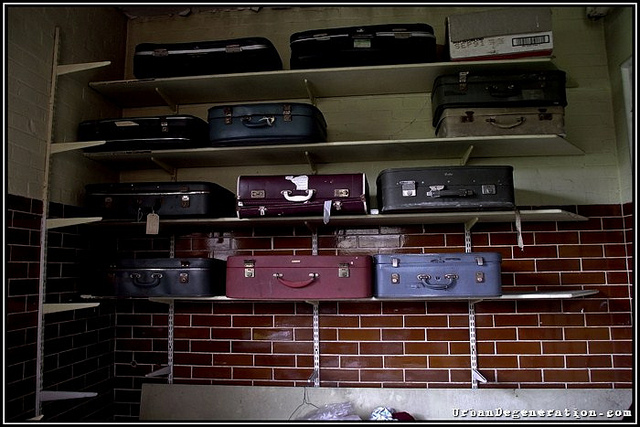

In [115]:
image_name = 'COCO_test2015_' + str(int(test_img_id[idx])).zfill(12)+'.jpg'
if not os.path.exists(image_name):
    logging.info('Downloading training dataset.')
    download(url_format.format('test_images/'+image_name),overwrite=True)

from IPython.display import Image
print("Image:")
Image(filename=image_name)

In [116]:
dataset = json.load(open('atoi.json'))
ans = dataset['ix_to_ans'][str(output[idx]+1)]
print("Answer:", ans)

Answer: wood


## Training_model2
* model2는 count_sketch 연산이 gpu에서만 가능하여 DGX 서버 이용